In [7]:
import numpy as np
import scipy
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
###pp%matplotlib inline
import sys
import pandas as pd
import os
os.environ["PROJ_LIB"] = "/rds/general/user/kc1116/home/anaconda3/envs/zeus/share/proj"
import matplotlib as mpl
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import somoclu
import cartopy
import xarray
import xarray as xr
import glob
import math
from mpl_toolkits.basemap import Basemap as bm
from itertools import groupby
from scipy import stats
import cartopy.crs as ccrs
from statsmodels.stats.multitest import (multipletests, fdrcorrection,
                                         fdrcorrection_twostage,
                                         NullDistribution,
                                         local_fdr)
from scipy.stats import spearmanr, kendalltau, pearsonr
from functools import wraps
import errno
import os
import signal
import SOM_trends_funcs as SOM_fn

After these plots are produced and studied, we should be able to explain some of why the F1 scores in some cases are very low and in other casesa rea very high. This can motivate choice of node number of using a different algorithm to select the BMU.

In [2]:
def create_nodes_arr_sq(rowcol):
    """
    Create the arrangement of nodes to label the set
    assumes a square arrangement of nodes
    """
    arr = np.ones((rowcol, rowcol))
    for i in range(rowcol):
        arr[i] = arr[i]*range(1+rowcol*i,rowcol+1+rowcol*i)
    return arr

In [3]:
def SOM_data_node_list(SOM_data, nodes_arr):
    """
    Define the 1d list of nodes from the bmus arrangement
    """
    SOM_data_node_list_tot = [(SOM_data[:,:,i]*nodes_arr).sum(axis=0).sum(axis=0) for i in range(SOM_data.shape[2])]
    SOM_data_node_list_tot_concat = xr.concat(SOM_data_node_list_tot, dim="time")
    return SOM_data_node_list_tot_concat

In [4]:

def plot_hist_blo_cv(blocking_occ, SOM_nodenum, savefig_str, num_nodes, caption=0):
    """
    Plot the histograms of blocking for the GTD and not in the GTD
    Overlay the plots for the training and test periods to investigate if there is a
    significant difference between the performance of the blocked vs non-blocked cases
    """
    alpha_val = 0.6
    nodes_notblo = SOM_nodenum.values*(blocking_occ==0).values
    nodes_blo = SOM_nodenum.values*blocking_occ.values
    freq_blo, freq_notblo = int(float(blocking_occ.mean())*1000)/10, int(float((blocking_occ==0).mean()*1000))/10
    nodes_blo_rem, nodes_notblo_rem = nodes_blo[nodes_blo != 0], nodes_notblo[nodes_notblo != 0]

    fig, ax = plt.subplots(1,1)
    ax.hist(nodes_notblo_rem-0.5, bins = np.arange(0.5,num_nodes+1.5,1), density = True, alpha = alpha_val, label = f"not blocked ({freq_notblo}% of days)", ec = "k") 
    ax.hist(nodes_blo_rem-0.5, bins = np.arange(0.5,num_nodes+1.5,1), density = True, alpha = alpha_val, label = f"blocked ({freq_blo}% of days)", ec = "k") 

    if caption != 0:
        ax.set_xlabel(f"SOM node number \n \n {caption}")
    else:
        ax.set_xlabel(f"SOM node number")
    ax.set_ylabel("Frequency of occurence")
    ax.set_xticks(np.arange(1,num_nodes+1,1))
    ax.legend()

    fig.savefig(savefig_str, bbox_inches="tight", dpi = 300)

In [10]:


GTD_str = "/rds/general/project/nowack_graven/live/carl_som_index/data/GTD_1979-2019_JJAextd.nc"
GTD_str = "/rds/general/project/nowack_graven/live/carl_som_index/data/GTD_UKESM1-0-LL_piControl_1960-2060_JJAextd.nc"
rowcol = 3
num_nodes = 9

if "UK" in GTD_str:
    rowcol = 3 # currently assuming square arrangement of nodes
    persis_thresh = 5
    #number of years in training dataset
    k_idx = 2
    k_arr =        [4, 5, 10,20]
    yrnum_cv_arr = [25,20,10, 5]
else:
    rowcol = 3 # currently assuming square arrangement of nodes
    persis_thresh = 5
    k_idx = 2
    #number of years in training dataset
    k_arr =        [ 2,  4, 5, 8, 10, 20]
    yrnum_cv_arr = [20, 10, 8, 5,  4,  2]
    
k = k_arr[k_idx]
yrnum_cv = yrnum_cv_arr[k_idx]
#load the data
if "1979-2019" in GTD_str:
    GTD = xr.open_dataset(GTD_str)['blocking']
    mdl, ens = "era5", "reanal"
if "UKESM" in GTD_str:
    mdl, ens = "UKESM1-0-LL", "r1i1p1f2"
    GTD = xr.open_dataset(GTD_str)['blocked']
#only select JJA from GTD
F1_cv_cross_arr, F1_cv_F1_arr = [], []
yrst, yrend = int(GTD['time.year'].min()), int(GTD['time.year'].max())
yrst_cv_arr = [yrst+i*yrnum_cv for i in range(int((yrend - yrst)/yrnum_cv))]
years_cv_str_arr, F1_cv_arr = [], []

1960
1985
2010
2035


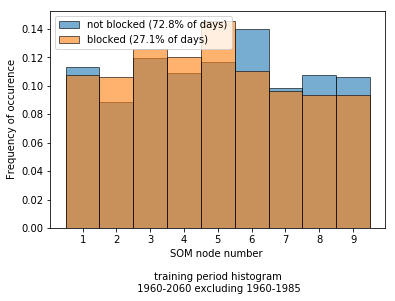

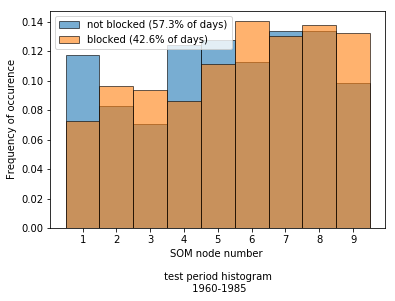

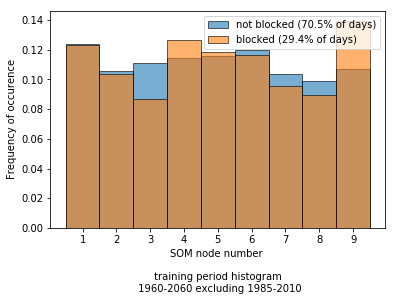

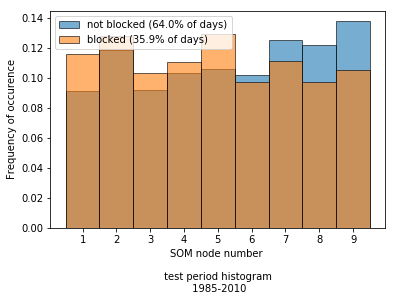

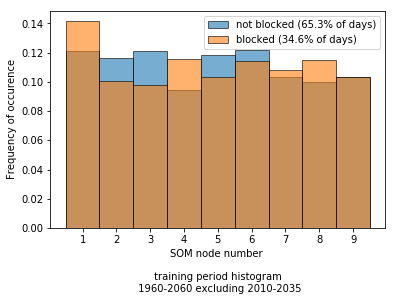

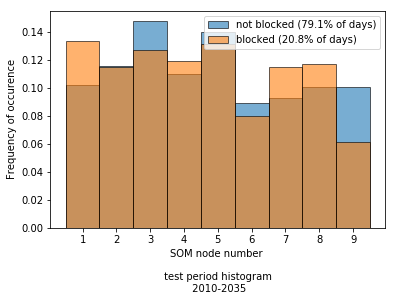

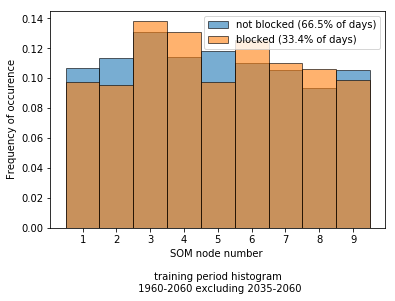

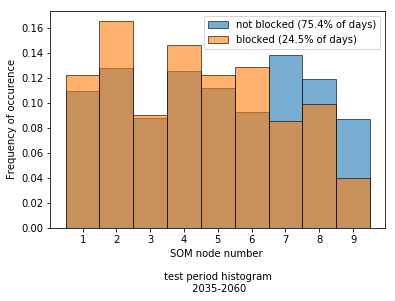

In [9]:


for yrst_train in yrst_cv_arr[:]:
    print(yrst_train)
    #define strings for the input GTD and SOM data
    ###/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/10-fold/
    SOM_data_str = f"/rds/general/project/nowack_graven/live/carl_som_index/data/SOM_data_occur_era5_reanal_{rowcol}x{rowcol}_EUR_1979-2019_JJA_extd_z_LTDManom.nc"
    SOM_data_str_train = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_data_occur_train_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    SOM_data_str_test = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_data_occur_cv_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    #define string for output figures
    fig_str_SOM_GTD_hist_train = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_train_not{yrst_train}-{yrst_train+yrnum_cv}.png"
    fig_str_SOM_GTD_hist_test = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_test_{yrst_train}-{yrst_train+yrnum_cv}.png"

    SOM_data_train = xr.open_dataset(SOM_data_str_train)['SOM_data']
    SOM_data_test = xr.open_dataset(SOM_data_str_test)['SOM_data']

    GTD_JJA = GTD.sel(time = np.isin(GTD['time.season'], "JJA"))
    GTD_data_train = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    GTD_data_test = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))
    nodes_arr = create_nodes_arr_sq(rowcol)
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)    
        
    SOM_data_node_list_test_JJA = SOM_data_node_list_test.sel(time = np.isin(SOM_data_node_list_test['time.season'], "JJA"))
    SOM_data_node_list_test_sel = SOM_data_node_list_test_JJA.sel(time = np.isin(SOM_data_node_list_test_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))

    SOM_data_node_list_train_JJA = SOM_data_node_list_train.sel(time = np.isin(SOM_data_node_list_train['time.season'], "JJA"))
    SOM_data_node_list_train_sel = SOM_data_node_list_train_JJA.sel(time = np.isin(SOM_data_node_list_train_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)

    
    SOM_data_node_list_train.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/SOM/trends/UK-ESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_node_list_train_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")

    SOM_data_node_list_test.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/SOM/trends/UK-ESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_node_list_test_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    GTD_data_train_sel = GTD_data_train.sel(time = np.isin(GTD_data_train['time'], SOM_data_node_list_train_sel['time']))
    GTD_data_test_sel = GTD_data_test.sel(time = np.isin(GTD_data_test['time'], SOM_data_node_list_test_sel['time']))
    
    
    plot_hist_blo_cv(GTD_data_train_sel, SOM_data_node_list_train_sel, fig_str_SOM_GTD_hist_train, num_nodes,
                     caption=f"training period histogram \n 1960-2060 excluding {yrst_train}-{yrst_train+yrnum_cv}")
    plot_hist_blo_cv(GTD_data_test_sel, SOM_data_node_list_test_sel, fig_str_SOM_GTD_hist_test, num_nodes,
                     caption=f"test period histogram \n {yrst_train}-{yrst_train+yrnum_cv}")

1960
1970
1980
1990
2000
2010
2020
2030
2040
2050


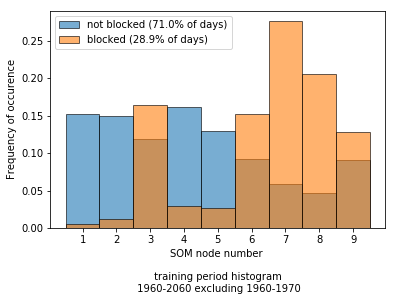

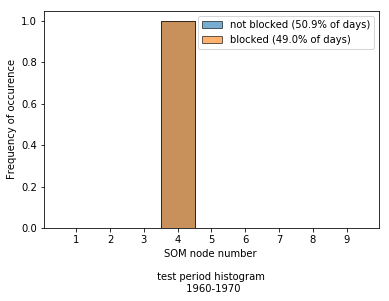

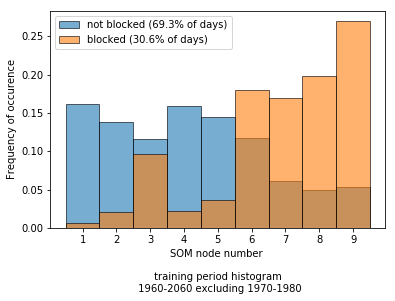

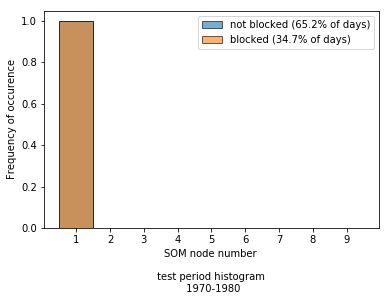

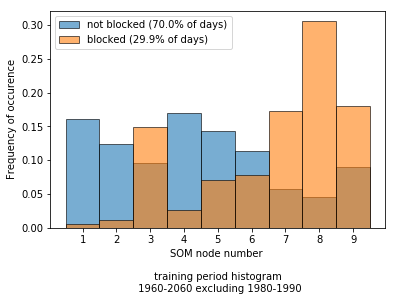

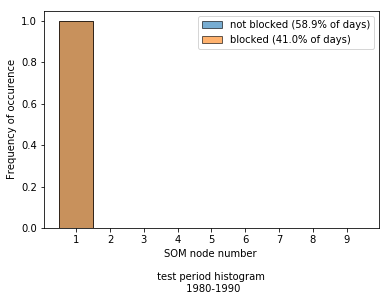

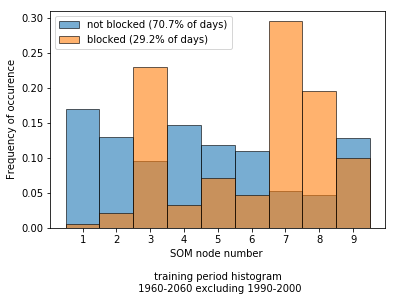

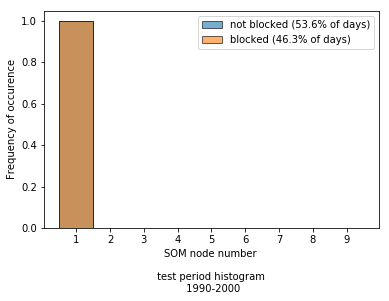

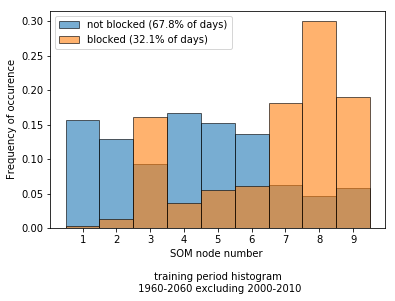

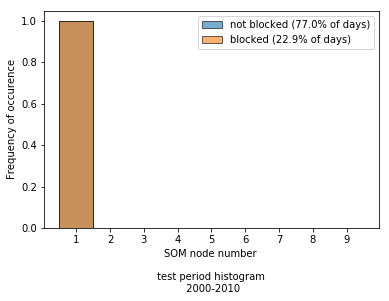

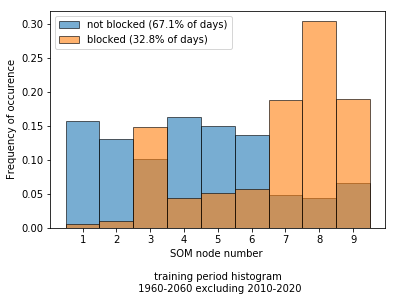

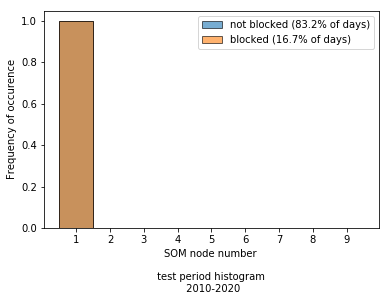

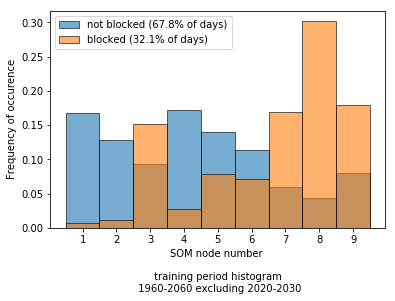

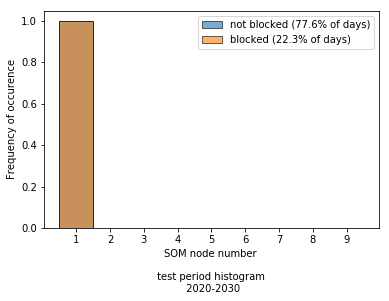

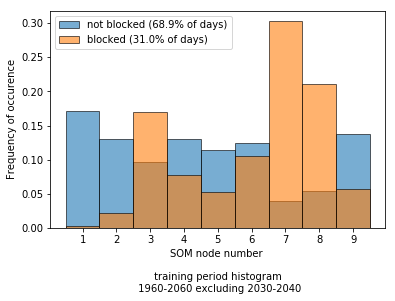

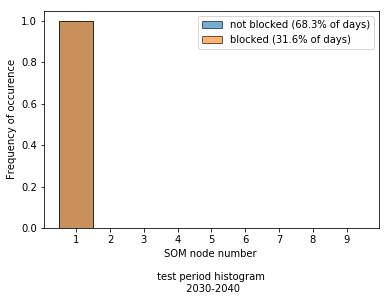

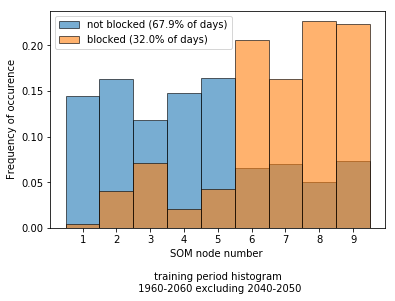

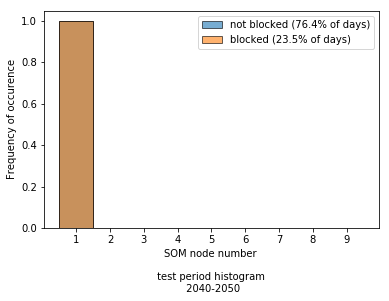

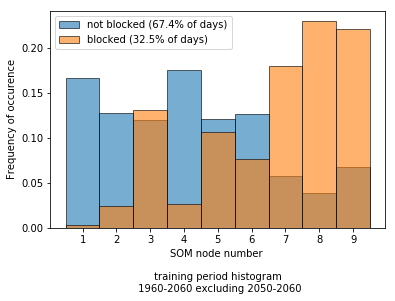

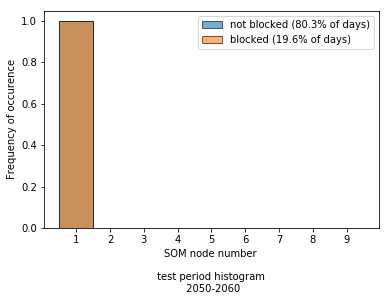

In [11]:


for yrst_train in yrst_cv_arr[:]:
    print(yrst_train)
    #define strings for the input GTD and SOM data
    ###/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/10-fold/
    SOM_data_str = f"/rds/general/project/nowack_graven/live/carl_som_index/data/SOM_data_occur_era5_reanal_{rowcol}x{rowcol}_EUR_1979-2019_JJA_extd_z_LTDManom.nc"
    SOM_data_str_train = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_data_occur_train_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    SOM_data_str_test = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_data_occur_cv_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    #define string for output figures
    fig_str_SOM_GTD_hist_train = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_train_not{yrst_train}-{yrst_train+yrnum_cv}.png"
    fig_str_SOM_GTD_hist_test = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_test_{yrst_train}-{yrst_train+yrnum_cv}.png"

    SOM_data_train = xr.open_dataset(SOM_data_str_train)['SOM_data']
    SOM_data_test = xr.open_dataset(SOM_data_str_test)['SOM_data']

    GTD_JJA = GTD.sel(time = np.isin(GTD['time.season'], "JJA"))
    GTD_data_train = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    GTD_data_test = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))
    nodes_arr = create_nodes_arr_sq(rowcol)
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)    
        
    SOM_data_node_list_test_JJA = SOM_data_node_list_test.sel(time = np.isin(SOM_data_node_list_test['time.season'], "JJA"))
    SOM_data_node_list_test_sel = SOM_data_node_list_test_JJA.sel(time = np.isin(SOM_data_node_list_test_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))

    SOM_data_node_list_train_JJA = SOM_data_node_list_train.sel(time = np.isin(SOM_data_node_list_train['time.season'], "JJA"))
    SOM_data_node_list_train_sel = SOM_data_node_list_train_JJA.sel(time = np.isin(SOM_data_node_list_train_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)

    
    SOM_data_node_list_train.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/SOM/trends/UK-ESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_node_list_train_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")

    SOM_data_node_list_test.to_netcdf(f"/rds/general/user/cmt3718/home/data/cmip6/SOM/trends/UK-ESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                    f"SOM_node_list_test_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    GTD_data_train_sel = GTD_data_train.sel(time = np.isin(GTD_data_train['time'], SOM_data_node_list_train_sel['time']))
    GTD_data_test_sel = GTD_data_test.sel(time = np.isin(GTD_data_test['time'], SOM_data_node_list_test_sel['time']))
    
    
    plot_hist_blo_cv(GTD_data_train_sel, SOM_data_node_list_train_sel, fig_str_SOM_GTD_hist_train, num_nodes,
                     caption=f"training period histogram \n 1960-2060 excluding {yrst_train}-{yrst_train+yrnum_cv}")
    plot_hist_blo_cv(GTD_data_test_sel, SOM_data_node_list_test_sel, fig_str_SOM_GTD_hist_test, num_nodes,
                     caption=f"test period histogram \n {yrst_train}-{yrst_train+yrnum_cv}")

In [6]:
mdl = "era5"
##/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/5-fold
for yrst_train in yrst_cv_arr[:]:
    print(yrst_train)
    #define strings for the input GTD and SOM data
    ###/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/10-fold/
    SOM_data_str = f"/rds/general/project/nowack_graven/live/carl_som_index/data/SOM_data_occur_era5_reanal_{rowcol}x{rowcol}_EUR_1979-2019_JJA_extd_z_LTDManom.nc"
    if mdl == "era5":#/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/5-fold
        SOM_data_str_train = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/{k}-fold/"
                        f"SOM_data_occur_train_{k}-fold_{mdl}_{ens}_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_z_LTDManom.nc")
        SOM_data_str_test = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/{k}-fold/"
                        f"SOM_data_occur_cv_{k}-fold_{mdl}_{ens}_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_z_LTDManom.nc")    
    elif mdl == "UK-ESM1-0-LL":
        SOM_data_str_train = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                        f"SOM_data_occur_train_{mdl}_{ens}_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
        SOM_data_str_test = (f"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/{k}-fold/"
                        f"SOM_data_occur_cv_{mdl}_{ens}_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    else:
        print("Incorrect definition of model")
    #define string for output figures
    fig_str_SOM_GTD_hist_train = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_train_not{yrst_train}-{yrst_train+yrnum_cv}.png"
    fig_str_SOM_GTD_hist_test = f"/rds/general/project/nowack_graven/live/carl_som_index/plots/zg/crossval/{k}-fold/z_GTD_blo_comp_hist_{rowcol}x{rowcol}_test_{yrst_train}-{yrst_train+yrnum_cv}.png"

    SOM_data_train = xr.open_dataset(SOM_data_str_train)['SOM_data']
    SOM_data_test = xr.open_dataset(SOM_data_str_test)['SOM_data']

    GTD_JJA = GTD.sel(time = np.isin(GTD['time.season'], "JJA"))
    GTD_data_train = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    GTD_data_test = GTD_JJA.sel(time = np.isin(GTD_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))
    nodes_arr = create_nodes_arr_sq(rowcol)
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)    
        
    SOM_data_node_list_test_JJA = SOM_data_node_list_test.sel(time = np.isin(SOM_data_node_list_test['time.season'], "JJA"))
    SOM_data_node_list_test_sel = SOM_data_node_list_test_JJA.sel(time = np.isin(SOM_data_node_list_test_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=False))

    SOM_data_node_list_train_JJA = SOM_data_node_list_train.sel(time = np.isin(SOM_data_node_list_train['time.season'], "JJA"))
    SOM_data_node_list_train_sel = SOM_data_node_list_train_JJA.sel(time = np.isin(SOM_data_node_list_train_JJA['time.year'], np.arange(yrst_train,yrst_train+yrnum_cv+1), invert=True))
    
    SOM_data_node_list_test = SOM_data_node_list(SOM_data_test, nodes_arr)
    SOM_data_node_list_train = SOM_data_node_list(SOM_data_train, nodes_arr)

    
    SOM_data_node_list_train.to_netcdf(f"/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/{k}-fold/"
                    f"SOM_node_list_train_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_not{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")

    SOM_data_node_list_test.to_netcdf(f"/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/{k}-fold/"
                    f"SOM_node_list_test_UKESM1-0-LL_r1i1p1f2_{rowcol}x{rowcol}_EUR_{yrst_train}-{yrst_train+yrnum_cv}_JJA_extd_zg_LTDManom.nc")
    GTD_data_train_sel = GTD_data_train.sel(time = np.isin(GTD_data_train['time'], SOM_data_node_list_train_sel['time']))
    GTD_data_test_sel = GTD_data_test.sel(time = np.isin(GTD_data_test['time'], SOM_data_node_list_test_sel['time']))
    
    
    plot_hist_blo_cv(GTD_data_train_sel, SOM_data_node_list_train_sel, fig_str_SOM_GTD_hist_train, num_nodes,
                     caption=f"training period histogram \n 1960-2060 excluding {yrst_train}-{yrst_train+yrnum_cv}")
    plot_hist_blo_cv(GTD_data_test_sel, SOM_data_node_list_test_sel, fig_str_SOM_GTD_hist_test, num_nodes,
                     caption=f"test period histogram \n {yrst_train}-{yrst_train+yrnum_cv}")

1960


FileNotFoundError: [Errno 2] No such file or directory: b'/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/4-fold/SOM_data_occur_train_4-fold_era5_r1i1p1f2_3x3_EUR_not1960-1985_JJA_extd_z_LTDManom.nc'